In [5]:
import warnings
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
load_dotenv()

import requests

from typing import List

from haystack import Document, Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.utils.auth import Secret


### Basic Haystack Component Creation

1. Use @component decorator before component class
2. Create a component class by the name of component you want to make
3. There should be a run method of the class
4. Output Types should be declared categorically suing @components.output_types(var_name=type)

In [2]:
@component
class Greeter:
    @component.output_types(greeting=str)
    def run(self, user_name: str = "Amad"):
        return {"greeting" : f"Hello, {user_name}"}

In [4]:
greeter = Greeter()
greeter.run(user_name="Ali")

{'greeting': 'Hello, Ali'}

### Add the Component to a Pipeline 

In [7]:
template = """ You will be given the beginning of a dialogue. 
Create a short play script using this as the start of the play.
Start of dialogue: {{ dialogue }}
Full script: 
"""

prompt = PromptBuilder(template = template)
llm = OpenAIGenerator(api_key = Secret.from_env_var("GROQ_API_KEY"),
                      api_base_url = "https://api.groq.com/openai/v1",
                      model="llama3-8b-8192",
                      generation_kwargs = {"max_tokens": 512}                      
                      )

dialog_pipeline = Pipeline()
dialog_pipeline.add_component("greeter", greeter)
dialog_pipeline.add_component("prompt", prompt)
dialog_pipeline.add_component("llm", llm)

dialog_pipeline.connect("greeter.greeting", "prompt.dialogue")
dialog_pipeline.connect("prompt", "llm")

🚅 Components
  - greeter: Greeter
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - greeter.greeting -> prompt.dialogue (str)
  - prompt.prompt -> llm.prompt (str)

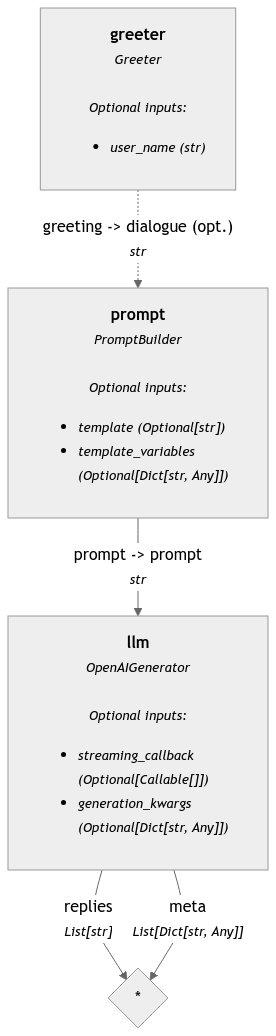

In [8]:
dialog_pipeline.show()

In [10]:
dialog = dialog_pipeline.run(
    {
        "greeter": {"user_name" : "Ali"}
    }
)
print(dialog["llm"]["replies"][0])

The completion for index 0 has been truncated before reaching a natural stopping point. Increase the max_tokens parameter to allow for longer completions.


Here is a short play script based on the start of the dialogue:

**"The Reunion"**

**Characters:**

* **Ali**, a successful businesswoman in her late 30s
* **Emma**, an old friend from high school, now in her early 30s

**Setting:** A trendy coffee shop in a busy city

**Script:**

**(The scene opens with Ali sitting at a small table in the coffee shop, sipping a latte. Emma bursts in, looking flustered, and spots Ali.)**

Emma: Hello, Ali!

Ali: (smiling) Emma! It's been ages! What brings you here today?

Emma: (out of breath) Oh, just needed a caffeine fix. And I saw your name on the list and thought, why not? (she looks around the coffee shop) Wow, this place has changed a lot.

Ali: (laughs) Yeah, it has. I come here all the time for meetings. So, what have you been up to?

Emma: (sits down across from Ali) Oh, you know, just trying to make a living. Freelancing, odd jobs... nothing too exciting.

Ali: (sympathetic) Ah, that sounds tough. I'm sorry to hear it's not going well.

Em

In [12]:
dialog = dialog_pipeline.run({})
print(dialog["llm"]["replies"][0])

The completion for index 0 has been truncated before reaching a natural stopping point. Increase the max_tokens parameter to allow for longer completions.


Here is a short play script using the given dialogue as the start:

Title: The Art of Memories

Characters:

* MARIA, a painter
* AMAD, a collector

Act 1:

(The scene is set in Maria's studio, where she is working on a new piece. Amad, a wealthy collector, enters the room.)

MARIA: Hello, Amad.

AMAD: Maria, it's been too long. Your work has been on my mind lately.

MARIA: (looks up from her canvas) Ah, thank you. I've been experimenting with new techniques.

AMAD: (walks closer) I can see that. Your use of color is stunning.

MARIA: (smiles) Thank you. I've been inspired by my travels.

AMAD: (stops in front of a painting) This one, in particular, catches my eye. Who is the subject?

MARIA: (steps back) That's a piece from my time in Paris. It's a portrait of my grandmother.

AMAD: (eyes linger on the painting) Your grandmother was a remarkable woman, I'm sure.

MARIA: (nods) She was. Full of life and stories. And art. She encouraged me to pursue my passion from a young age.

AMAD: (